### Fetch item and category information

In [3]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
%matplotlib inline

# Load the item ids from the dataset
df = pd.read_hdf("filtered_data.hdf", "df1")
df = df[(df.type == 'page_view')]
df['item_id'] = df.data.apply(lambda x: x.replace('/item/', ''))
df['item_id'] = df.item_id.apply(lambda x: x if x.isdigit() else None)
item_ids = [int(item_id) for item_id in df['item_id'] if item_id is not None]

# Connect to the database and fetch category information
connection = pymysql.connect(host='kidup-production.c5gkrouylqmw.eu-central-1.rds.amazonaws.com',
                             user='kidup_148161251',
                             password='knop0602R',
                             db='kidup',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

# One query for loading all item ids and category ids
df_item = pd.read_sql_query("select item.id as item_id, category.id as category_id, category.name as name from item inner join category on category.id = item.category_id where item.min_renting_days != 666", connection)
category_per_item = {}
category_labels = {}
for tuple in df_item.itertuples():
    category_per_item[tuple.item_id] = tuple.category_id
    category_labels[tuple.category_id] = tuple.name

### Calculate the number of page views per category

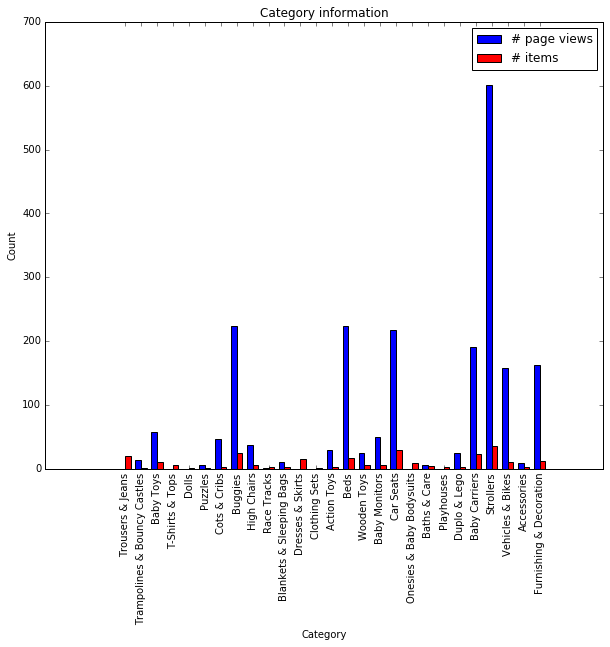

In [4]:
import numpy as np
import matplotlib

# Initialize the counts
counts_activity = {}
counts_num_items = {}
for category_id in category_per_item.values():
    category_label = category_labels[category_id]
    counts_activity[category_label] = 0
    counts_num_items[category_label] = 0

# Count the activity per category
for item_id in item_ids:
    if item_id in category_per_item.keys():
        category_id = category_per_item[item_id]
        category_label = category_labels[category_id]
        counts_activity[category_label] += 1

# Count the number of items per category
for item_id in category_per_item:
    counts_num_items[category_labels[category_per_item[item_id]]] += 1

# Make a plot of the counts
bar_width = 0.35
bar_activity = plt.bar(np.arange(len(counts_activity)) - 0.5 * bar_width, counts_activity.values(), bar_width, color='b', align='center', label='# page views')
bar_num_items = plt.bar(np.arange(len(counts_num_items)) + 0.5 * bar_width, counts_num_items.values(), bar_width, color='r', align='center', label='# items')
plt.xticks(range(len(counts_activity)), counts_activity.keys())
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()
plt.title('Category information')
plt.xlabel('Category')
plt.ylabel('Count')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.show()

Many of the categories are not viewed at all, although they contain many items. It seems usable to drop these categories since they do not improve the traffic stream (for example T-Shirts & Tops).
Clothing related categories do not contribute to the traffic stream at all.

### View the number of user generated items per category

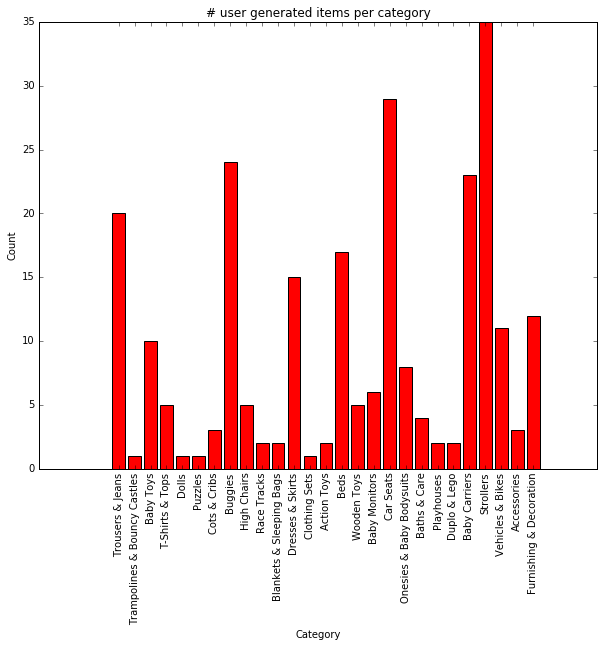

In [5]:
import numpy as np
import matplotlib

# Make a plot of the counts
bar_num_items = plt.bar(np.arange(len(counts_num_items)), counts_num_items.values(), color='r', align='center', label='# items')
plt.xticks(range(len(counts_num_items)), counts_activity.keys())
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('# user generated items per category')
plt.xlabel('Category')
plt.ylabel('Count')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.show()

More items per category means roughly more traffic.

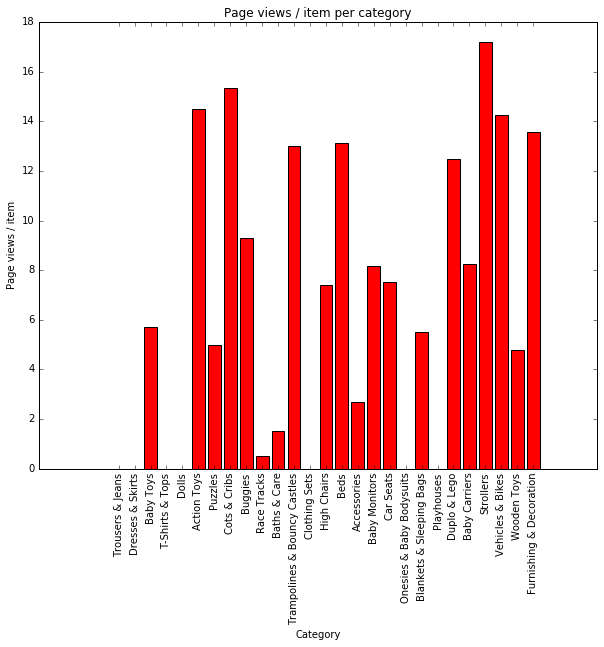

In [21]:
import numpy as np
import matplotlib

ratio = {}
for category_label in category_labels.values():
    ratio[category_label] = counts_activity[category_label] / counts_num_items[category_label]

# Make a plot of the counts
bar_num_items = plt.bar(np.arange(len(ratio)), ratio.values(), color='r', align='center', label='# items')
plt.xticks(range(len(ratio)), ratio.keys())
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.title('Page views / item per category')
plt.xlabel('Category')
plt.ylabel('Page views / item')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 8)

plt.show()

Note that users are interested in toys, beds, vehicles, strollers, decoration and certainly not in clothing. There are more page views per item on "kids" categories than for "baby" categories.